In [8]:
%matplotlib inline
%run 'bin/notebook_utils.py'
%run 'bin/plot_utilization.py'

In [9]:
# RP sessions with general purpose scheduler for all scales
ws_path = '../rawdata/weak_scaling_synapse_titan/optimized'
ss_path = '../rawdata/strong_scaling_synapse_titan'
t_path  = '../rawdata/tests'
sources = ['%s/ws_syn_titan_32_32_1024_60_1.0'           % ws_path,
           '%s/ws_syn_titan_64_32_2048_60_2.0'           % ws_path,
           '%s/ws_syn_titan_128_32_4096_60_3.0'          % ws_path,
           '%s/ws_syn_titan_256_32_8192_60_4.0'          % ws_path,
           '%s/ws_syn_titan_512_32_16384_60_5.0'         % ws_path,
           '%s/ws_syn_titan_1024_32_32768_60_6.1'        % ws_path,
           '%s/ws_syn_titan_2048_32_65536_60_7.0'        % ws_path,
           '%s/ws_syn_titan_4096_32_131072_60_8.0'       % ws_path,
           '%s/rp.session.titan-ext1.itoman.017491.0004' % ss_path,
           '%s/rp.session.titan-ext2.itoman.017467.0000' % ss_path,
           '%s/rp.session.titan-ext1.itoman.017501.0001' % ss_path]

# RP sessions with workload specific scheduler (HOMBRE)
data_sch = dict()
sch_path = '../rawdata/scheduling/'
sources_sch = ['%s/rp.session.titan-ext1.merzky1.017832.0006' % sch_path,
               '%s/rp.session.titan-ext1.merzky1.017832.0007' % sch_path]

# RP sessions with general purpose scheduler for two scales
data_sws = dict()
sws_path = '../rawdata/weak_scaling_synapse_titan/optimized'
sources_sws = ['%s/ws_syn_titan_2048_32_65536_60_7.0' % sws_path,
               '%s/ws_syn_titan_256_32_8192_60_4.0'   % sws_path]

In [10]:
# Durations for all the scales used in the paper (WARNING: It takes several minutes to run.)
# Version: for < Nov 2018 sessions we need different event names.
# xkeys: separate entry in the utilization dict for each source (session)
#
version = '2017'
utilization = dict() # dict of contributions to utilization
data  = dict()       # the numbers we ultimately plot
sids  = list()       # used for labels
xkeys = list()       # x-axis labels
data, sids, utilization, xkeys = get_utilization_durations(sources, version)

../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_32_32_1024_60_1.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_64_32_2048_60_2.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_128_32_4096_60_3.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_256_32_8192_60_4.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_512_32_16384_60_5.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_1024_32_32768_60_6.1.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_2048_32_65536_60_7.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_4096_32_131072_60_8.0.tbz
../rawdata/strong_scaling_synapse_titan/rp.session.titan-ext1.itoman.017491.0004.tbz
../rawdata/strong_scaling_synapse_titan/rp.session.titan-ext2.itoman.017467.0000.tbz
extract tarball to ../rawdata/strong_scaling_synapse_titan/rp.session.titan-ext2.itoman.017467.0000
../rawdata/strong_scaling_synapse_titan/rp.session.t

In [11]:
# Durations for all the scales used in the paper (WARNING: It takes several minutes to run.)
# Version: for < Nov 2018 sessions we need different event names.
# xkeys: separate entry in the utilization dict for each source (session)
#
version = '2017'
utilization_sws = dict() # dict of contributions to utilization
data_sws  = dict()       # the numbers we ultimately plot
sids_sws  = list()       # used for labels
xkeys_sws = list()       # x-axis labels
data_sws, sids_sws, utilization_sws, xkeys_sws = get_utilization_durations(sources_sws, version)

../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_2048_32_65536_60_7.0.tbz
../rawdata/weak_scaling_synapse_titan/optimized/ws_syn_titan_256_32_8192_60_4.0.tbz


In [12]:
# Durations for all the scales used in the paper (WARNING: It takes several minutes to run.)
# Version: for < Nov 2018 sessions we need different event names.
# xkeys: separate entry in the utilization dict for each source (session)
#
version = '2018'
utilization_sch = dict() # dict of contributions to utilization
data_sch  = dict()       # the numbers we ultimately plot
sids_sch  = list()       # used for labels
xkeys_sch = list()       # x-axis labels
data_sch, sids_sch, utilization_sch, xkeys_sch = get_utilization_durations(sources_sch, version)

../rawdata/scheduling//rp.session.titan-ext1.merzky1.017832.0006.tbz
../rawdata/scheduling//rp.session.titan-ext1.merzky1.017832.0007.tbz
conflicting time sync for bootstrap_0.prof                              (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.18 -      -4.77 =  4.59
conflicting time sync for agent_0.prof                                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.18 -      -4.77 =  4.59
conflicting time sync for agent_0.prof                                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.04 -      -4.77 =  4.73
conflicting time sync for agent_0.staging.input.0.prof                  (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.01 -      -4.77 =  4.76
conflicting time sync for agent_0.staging.output.0.prof                 (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.02 -      -4.77 =  4.75
conflicting time sync for agent_0.staging.input.0.child.prof            (titan-batch3.ccs.ornl.gov:10.128.36.164):      -0.02 -

/Users/mturilli/Virtualenvs/experiments/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


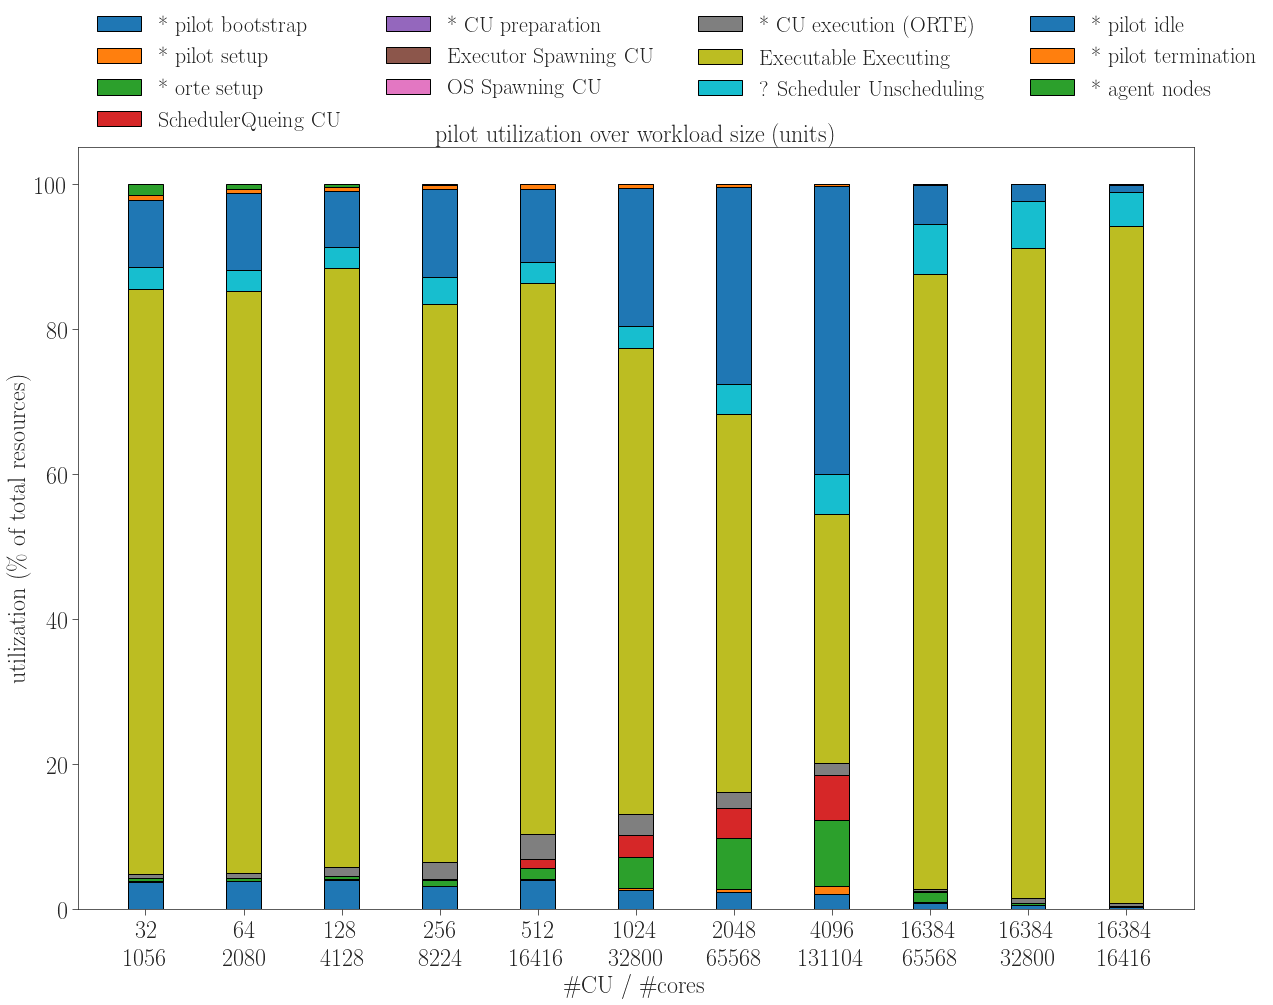

In [13]:
# do the stacked barplots - yes, it is this cumbersome:
# http://matplotlib.org/examples/pylab_examples/bar_stacked.html
plt.figure(figsize=(20,14))
bottom = np.zeros(len(xkeys))
labels = list()
plots  = list()
ind    = np.arange(len(sids))  # locations for the bars on the x-axis
width  = 0.35                  # width of the bars

for key in ORDERED_KEYS:
    assert(len(data[key]) == len(ind))
    plots.append(plt.bar(ind, data[key], width, bottom=bottom))
    bottom += data[key]
    labels.append(TRANSLATE_KEYS[key])

if ABSOLUTE: plt.ylabel('utilization (% of total resources)')
else       : plt.ylabel('utilization (in core-seconds)')

plt.xlabel('\#CU / \#cores')
plt.ylabel('utilization (\% of total resources)')
plt.title ('pilot utilization over workload size (#units)')
plt.xticks(ind, xkeys)
handles = [p[0] for p in plots]
plt.legend(handles, labels, ncol=4, loc='upper left', bbox_to_anchor=(0,1.2))
plt.savefig('figures/paper_titan_rp_synapse_utilization.pdf')


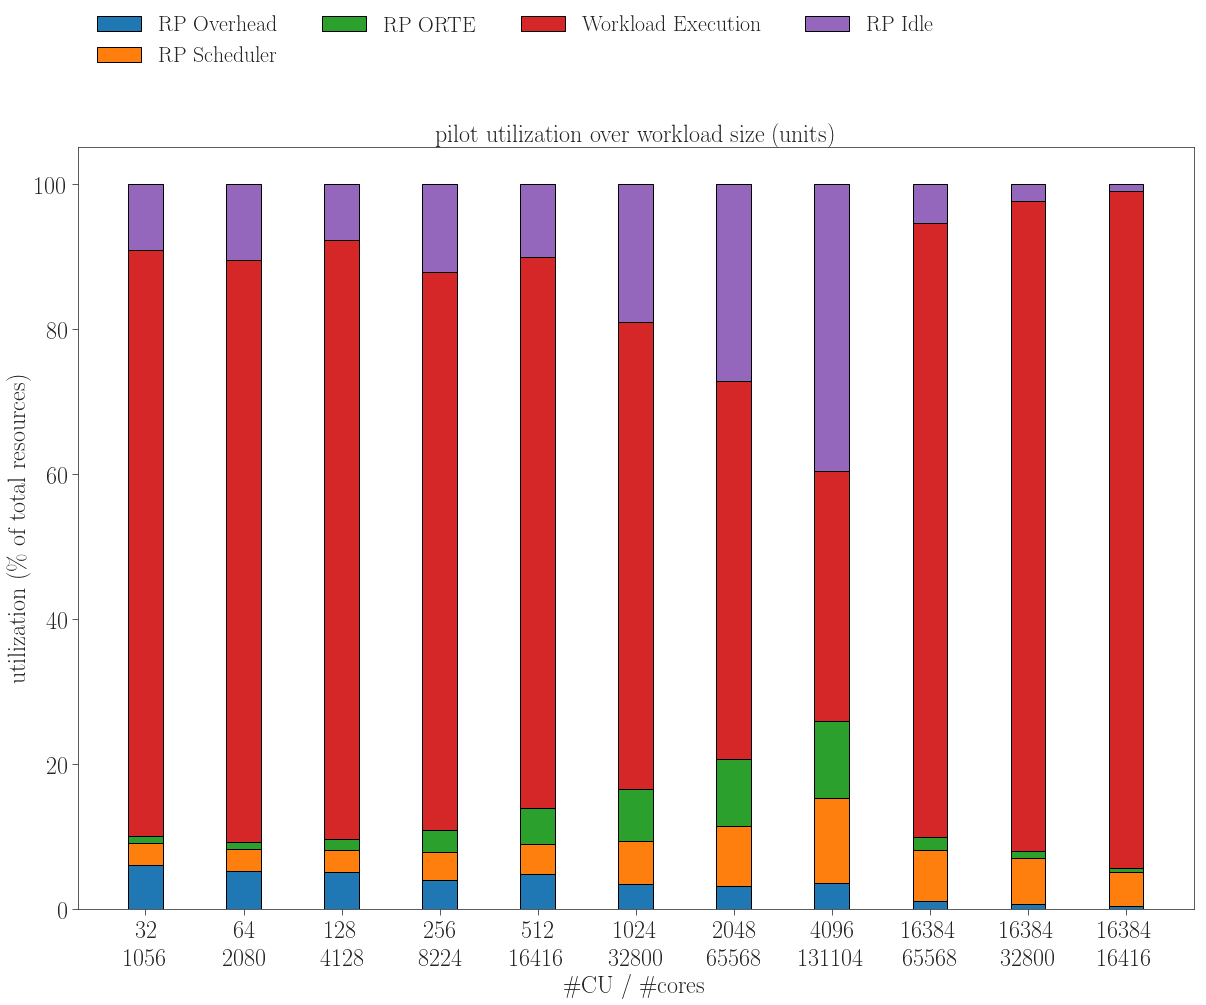

In [15]:
    # do the stacked barplots - yes, it is this cumbersome:
    # http://matplotlib.org/examples/pylab_examples/bar_stacked.html
    plt.figure(figsize=(20,14))
    bottom = np.zeros(len(xkeys))
    labels = list()
    plots  = list()
    ind    = np.arange(len(sids))  # locations for the bars on the x-axis
    width  = 0.35                  # width of the bars
    
    for key in ORDERED_KEYS_1:
        assert(len(data_sum_1[key]) == len(ind)), '%s != %s' % (len(data_sum_1[key]), len(ind))
        plots.append(plt.bar(ind, data_sum_1[key], width, bottom=bottom))
        bottom += data_sum_1[key]
        labels.append(TRANSLATE_KEYS[key])

    if ABSOLUTE: plt.ylabel('utilization (% of total resources)')
    else       : plt.ylabel('utilization (in core-seconds)')

    plt.xlabel('\#CU / \#cores')
    plt.ylabel('utilization (\% of total resources)')
    plt.title ('pilot utilization over workload size (#units)')
    plt.xticks(ind, xkeys)
    handles = [p[0] for p in plots]
    plt.legend(handles, labels, ncol=4, loc='upper left', bbox_to_anchor=(0,1.2))
    plt.savefig('figures/paper_titan_rp_synapse_utilization.pdf')


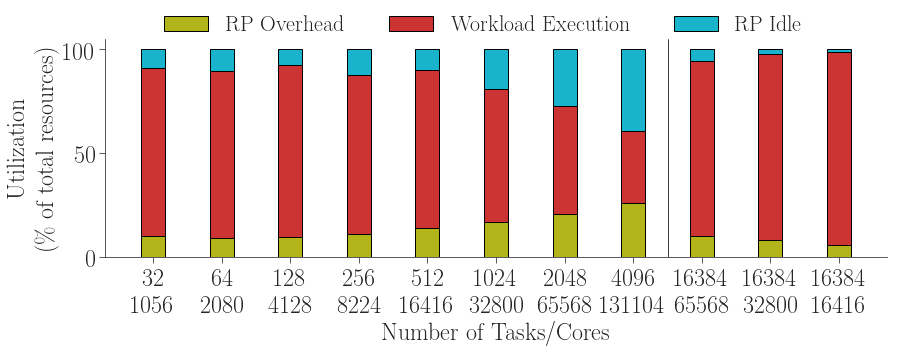

In [16]:
# do the stacked barplots - yes, it is this cumbersome:
# http://matplotlib.org/examples/pylab_examples/bar_stacked.html
plt.figure(figsize=(14,4))
plt.gca().set_prop_cycle(cycler('color', [tableau20[14],tableau20[6],tableau20[16]]))
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

bottom = np.zeros(len(xkeys))
labels = list()
plots  = list()
ind    = np.arange(len(sids))  # locations for the bars on the x-axis
width  = 0.35                  # width of the bars

for key in ORDERED_KEYS_2:
    assert(len(data_sum_2[key]) == len(ind)), '%s != %s' % (len(data_sum_2[key]), len(ind))
    plots.append(plt.bar(ind, data_sum_2[key], width, bottom=bottom))
    bottom += data_sum_2[key]
    labels.append(TRANSLATE_KEYS[key])

plt.axvline(x=7.5, color='black', linewidth=0.75)
    
plt.xlabel('Number of Tasks/Cores')
plt.ylabel('Utilization\n(\% of total resources)')
plt.xticks(ind, xkeys)

handles = [p[0] for p in plots]
plt.legend(handles, labels, ncol=4, loc='upper left', bbox_to_anchor=(0.05,1.2))

plt.savefig('figures/paper_titan_rp_synapse_utilization.pdf', dpi=300, bbox_inches='tight')


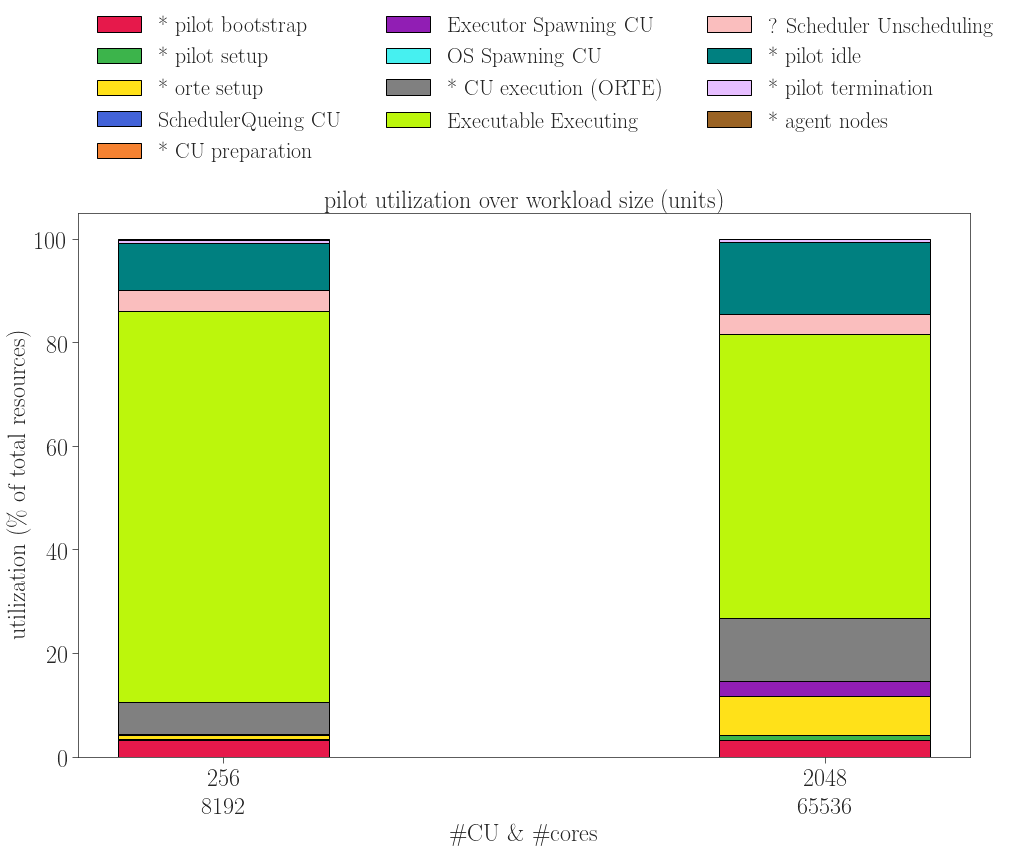

In [44]:
# do the stacked barplots - yes, it is this cumbersome:
# http://matplotlib.org/examples/pylab_examples/bar_stacked.html

plt.figure(figsize=(16,10))

bottom = np.zeros(len(xkeys_sch))
labels = list()
plots  = list()
ind    = np.arange(len(sids_sch))  # locations for the bars on the x-axis
width  = 0.35 # width of the bars

colors = {'p_boot'      :'#e6194b',
          'p_setup'     :'#3cb44b',
          'p_orte'      :'#ffe119',
          'u_equeue'    :'#4363d8',
          'u_eprep'     :'#f58231',
          'u_exec_rp'   :'#911eb4',
          'u_exec_cu'   :'#46f0f0',
          'u_exec_orte' :'#808080',
          'u_exec_app'  :'#bcf60c',
          'u_unschedule':'#fabebe',
          'p_idle'      :'#008080',
          'p_term'      :'#e6beff',
          'p_agent'     :'#9a6324'}

for key in ORDERED_KEYS:
    assert(len(data_sch[key]) == len(ind))
    plots.append(plt.bar(ind, data_sch[key], width, bottom=bottom, color=colors[key]))
    bottom += data_sch[key]
    labels.append(TRANSLATE_KEYS[key])

if ABSOLUTE: plt.ylabel('utilization (% of total resources)')
else       : plt.ylabel('utilization (in core-seconds)')

plt.xlabel('\#CU \& \#cores')
plt.ylabel('utilization (\% of total resources)')
plt.title ('pilot utilization over workload size (#units)')
plt.xticks(ind, xkeys_sch)
handles = [p[0] for p in plots]
plt.legend(handles, labels, ncol=3, loc='upper left', bbox_to_anchor=(0,1.4))
# plt.savefig('figures/paper_titan_rp_synapse_utilization.pdf')


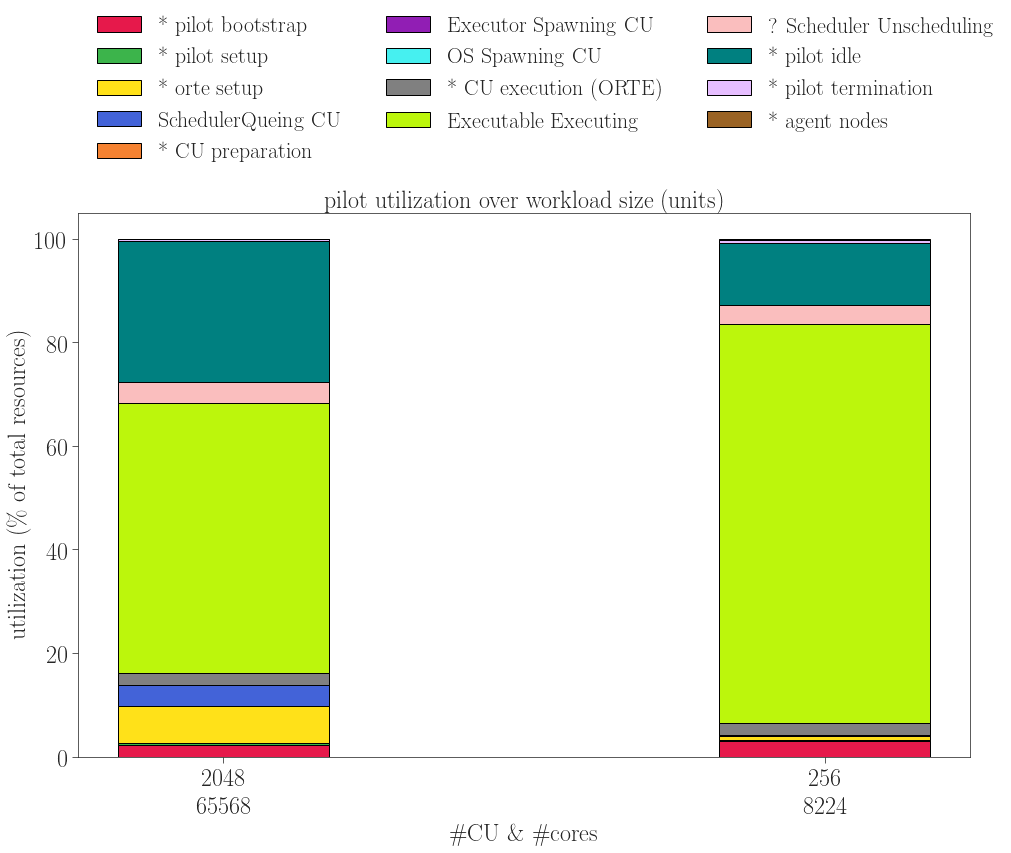

In [45]:
# do the stacked barplots - yes, it is this cumbersome:
# http://matplotlib.org/examples/pylab_examples/bar_stacked.html

plt.figure(figsize=(16,10))

bottom = np.zeros(len(xkeys_sws))
labels = list()
plots  = list()
ind    = np.arange(len(sids_sws))  # locations for the bars on the x-axis
width  = 0.35 # width of the bars

colors = {'p_boot'      :'#e6194b',
          'p_setup'     :'#3cb44b',
          'p_orte'      :'#ffe119',
          'u_equeue'    :'#4363d8',
          'u_eprep'     :'#f58231',
          'u_exec_rp'   :'#911eb4',
          'u_exec_cu'   :'#46f0f0',
          'u_exec_orte' :'#808080',
          'u_exec_app'  :'#bcf60c',
          'u_unschedule':'#fabebe',
          'p_idle'      :'#008080',
          'p_term'      :'#e6beff',
          'p_agent'     :'#9a6324'}

for key in ORDERED_KEYS:
    assert(len(data_sws[key]) == len(ind))
    plots.append(plt.bar(ind, data_sws[key], width, bottom=bottom, color=colors[key]))
    bottom += data_sws[key]
    labels.append(TRANSLATE_KEYS[key])

if ABSOLUTE: plt.ylabel('utilization (% of total resources)')
else       : plt.ylabel('utilization (in core-seconds)')

plt.xlabel('\#CU \& \#cores')
plt.ylabel('utilization (\% of total resources)')
plt.title ('pilot utilization over workload size (#units)')
plt.xticks(ind, xkeys_sws)
handles = [p[0] for p in plots]
plt.legend(handles, labels, ncol=3, loc='upper left', bbox_to_anchor=(0,1.4))
# plt.savefig('figures/paper_titan_rp_synapse_utilization.pdf')
